# Investigation of the Equilibrium Paths of the Unreinforced Box Beam

In our previous notebooks we have established that the equilibrium path of a box beam under a concetrated tip load is always stable and resembles the natural path of a broken supercritical pitchfork. In the case of Euler's column, the natural path is accompanied by the presence of a complementary path that cannot be reached from the ground state. Consequently, a legitimate question arises: is there any complementary path also in the case of our box beam?

A clue on the existence of complimentary paths for the box beam comes from the sensitivity study of the nonlinear analysis parameters that we carried out for the [box beam reinforced with ribs](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb#nonlinear-analysis-parameters) and for the [one reinforced with ribs and stiffeners](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb#nonlinear-analysis-parameters). In those cases we observed some differences in the load-displacement curves obtained using different nonlinear analysis parameters, and we attributed those differences to the varying accuracy of the solution, caused in turn by the different parameters used for the analysis. However, is it possible that the equilibrium points of those curves actually belong to a different equilibrium path than the natural one?

In this notebook we are going to investigate the possible presence of other paths in the equilibrium manifold of the unreinforced box beam, and we will play with the nonlinear analysis parameters to find those paths.

* [Setup of the numerical model](#numerical-model)
* [Variation of nonlinear analysis parameters](#nonlinear-analysis-parameters)
    * [Error function](#error-function)
    * [Convergence tolerance](#convergence-tolerance)
    * [Initial load increment](#initial-load-increment)
* [Verification of the existence of other equilibrium paths](#verification)
* [Visualization of 3D equilibrium diagram and of deformation shapes](#visualization)
* [Conclusion](#conclusion)

In [1]:
import matplotlib.pyplot as plt  # import matplotlib
import tol_colors as tc  # package for colorblind-friendly colors

plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))  # set default color cycle to TOL bright

## Setup of the numerical model <a name="numerical-model"></a>

***

Let's consider the same unreinforced box beam used in our previous notebooks.

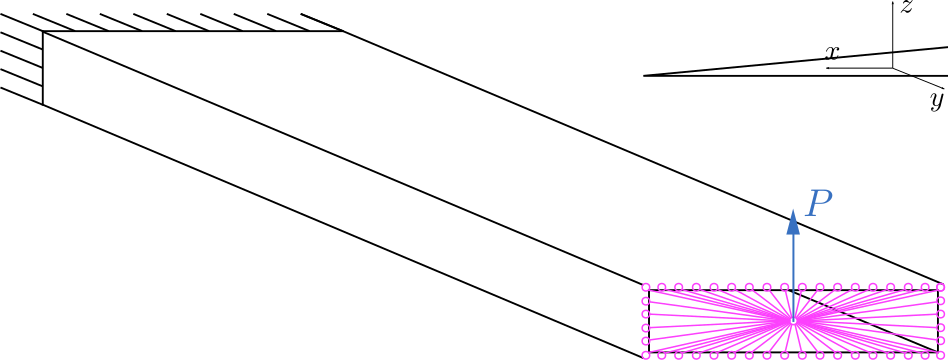

In [2]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '04_BoxBeamConcentratedLoad.svg'))

In [3]:
# Define geometry
AR = 9.   # aspect ratio - 2*b/w (the length of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
l = AR*w/2  # length [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.1f} m\n- length: {l/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm')

# Define material
rho = 2780e-12 # density [ton/mm^3]
E = 73.1e3 # Young's modulus [MPa]
nu = 0.3 # Poisson's ratio

Box beam dimensions:
- width: 1.0 m
- length: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


Let's define the mesh using a shell element of 59.9 mm, as found in a previous [mesh convergence study](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb#mesh-convergence). We use the function `mesh_box_with_pyvista` from the `box_beam_utils` module and then we call the function `create_base_bdf_input` from the same module, which generates a `BDF` object of our box beam with material properties, nodes, elements, boundary conditions and output files defaults. Finally, let's print a summary of the cards of our `BDF` object.

In [4]:
from resources import box_beam_utils

shell_element_length = 59.9  # [mm]
box_beam_mesh = box_beam_utils.mesh_box_with_pyvista(width=w, length=l, height=h, element_length=shell_element_length)
nodes_coordinates_array = box_beam_mesh.points
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t,
                                                    nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
print(box_beam_bdf.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 3388

bdf.elements: 0
  CQUAD4   : 3344

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Now we rigidly constrain the tip section of the box beam with `RBE2` elements and we add a concentrated unitary upward force at the center of the section by calling the function `add_unitary_force` from the `pynastran_utils` module.

In [5]:
import numpy as np
from resources import pynastran_utils  # module with useful functions to work with pyNastran objects

# Add master node of tip section
tip_master_node_id = np.size(nodes_coordinates_array, 0) + 1
box_beam_bdf.add_grid(tip_master_node_id, [w/2, l, 0.])

# Add RBE2 element to make tip section rigid
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tip_nodes_ids = nodes_ids[nodes_coordinates_array[:,1] == l]
rbe2_eid = len(box_beam_bdf.elements) + 1
box_beam_bdf.add_rbe2(rbe2_eid, tip_master_node_id, '123456', tip_nodes_ids)

# Add concentrated force
force_set_id = 11
concentrated_force_direction = [0., 0., 1.]
pynastran_utils.add_unitary_force(bdf_object=box_beam_bdf, nodes_ids=[tip_master_node_id], set_id=force_set_id, direction_vector=concentrated_force_direction)

Finally we set up the arc-length method with default parameters calling the function `set_up_arc_length_method` from the `pynastran_utils` module.

In [6]:
pynastran_utils.set_up_arc_length_method(box_beam_bdf)  # set up SOL 106 with arc-length method using default parameters

## Variation of nonlinear analysis parameters <a name="nonlinear-analysis-parameters"></a>

***

How can we find whether any complementary path exist in the equilibrium manifold of our box beam? As mentioned earlier, we can get a clue from our previous sensitivity studies on the nonlinear analysis parameters. For the box beams reinforced with ribs and with ribs and stiffeners we observed different load-displacement curves when varying certain nonlinear analysis parameters. The idea here is to select those parameters and for each value leading to a different final equilibrium point we run an analysis with two subcases. In the first subcase we use the same set of parameters to reproduce the final equilibrium point and in the second subcase we unload the structure with a very fine arc-length increment size, with the aim of tracking the equilibrium path with relatively high accuracy. In this way we will be able to verify whether the final equilibrium points belong to a different path than the natural one.

When we carried out the sensitivity study on the nonlinear analysis parameters for the [unreinforced box beam](05_Sensitivity_Study_of_SOL_106_Nonlinear_Analysis_Parameters.ipynb), we only loaded the structure up to the buckling load predicted by SOL 105, $P_\text{SOL 105}$, instead of twice its value, and consequently we did not observe any influence of the parameters on the load-displacement curves. For this reason, we are going to perform the sensitivity study again, this time loading the structure with $P/P_\text{SOL 105}=2$, until we find a parameter leading to different load-displacement curves. Once identified the parameter, we'll try to run an analysis with two subcases as described earlier.

To perform the sensitivity study let's first define a subcase with an applied load of $P/P_\text{SOL 105}=2$. We recall the buckling load predicted by SOL 105 for our box beam, add a LOAD card, and call the function `create_static_load_subcase` from the `pynastran_utils` module.

In [7]:
SOL_105_BUCKLING_LOAD = 1654.  # [N]
load_set_id = force_set_id + 1  # define id of LOAD card
box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[2*SOL_105_BUCKLING_LOAD], load_ids=[force_set_id])  # add LOAD card to define load set
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=1, load_set_id=load_set_id)  # create subcase with defined load set

### Error function <a name="error-function"></a>

Let's start by considering different combinations of error functions:
- load and energy (default);
- load and energy with vector component checking;
- load and displacement;
- load and displacement with vector component checking;
- load, energy and displacement;
- load, energy and displacement with vector component checking.

In [8]:
error_functions = ['PW', 'PWV', 'PU', 'PUV', 'PWU', 'PWUV']

To run the analyses with the different parameter settings, we first define the name of the analysis directory and then we define the function `plot_load_displacement_curve` to run the analysis and plot the resulting load-displacement curve on an already existing figure. We monitor the tip displacement $u_{z,\,tip}$ and nondimensionalize it with the length $l$ of the box beam.

In [9]:
from pyNastran.op2.op2 import read_op2  # function to read Nastran op2 files

analysis_directory_name = '14_Investigation_of_the_Equilibrium_Paths_of_the_Unreinforced_Box_Beam'
ANALYSIS_DIRECTORY_PATH = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
Z_COMPONENT_INDEX = 2  # index of the component of interest for displacements and loads (translation along z)

def plot_load_displacement_curve(bdf_input, filename, axes, marker_style, line_label, run_flag=True):
    # Run analysis
    pynastran_utils.run_analysis(directory_path=ANALYSIS_DIRECTORY_PATH, bdf_object=bdf_input, filename=filename, run_flag=run_flag)
    # Read load and displacement history from op2 file
    op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, filename + '.op2')
    op2 = read_op2(op2_filename=op2_filepath, debug=None)
    _, p, disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=tip_master_node_id)
    # Plot load-displacement curve on input axes
    axes.plot(disp[1][:,Z_COMPONENT_INDEX]/l, p[1][:, Z_COMPONENT_INDEX]/SOL_105_BUCKLING_LOAD, marker=marker_style, linestyle='-', label=line_label)

Let's find the load-equilibrium curves for the different combinations of error functions.

Nastran job nonlinear_analysis_error_function_PW.bdf completed
Wall time: 15.0 s


Nastran job nonlinear_analysis_error_function_PWV.bdf completed
Wall time: 13.0 s


Nastran job nonlinear_analysis_error_function_PU.bdf completed
Wall time: 18.0 s


Nastran job nonlinear_analysis_error_function_PUV.bdf completed
Wall time: 19.0 s


Nastran job nonlinear_analysis_error_function_PWU.bdf completed
Wall time: 18.0 s


Nastran job nonlinear_analysis_error_function_PWUV.bdf completed
Wall time: 19.0 s


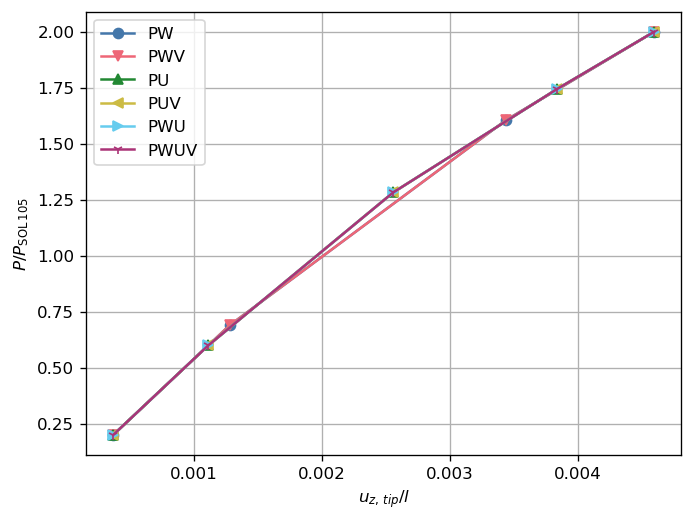

In [10]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

plt.rcParams['figure.dpi'] = 120  # set default dpi of figures
markers = list(Line2D.markers.keys())[2:]  # list of marker characters
nlparm_id = next(iter(box_beam_bdf.nlparms))  # retrieve id of NLPARM card
ax = plt.subplot()  # create figure with one subplot

# Run analysis for each set of error functions and plot load-displacement diagram
for count, fun in enumerate(error_functions):
    box_beam_bdf.nlparms[nlparm_id].conv = fun
    input_filename = "nonlinear_analysis_error_function_" + fun
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, markers[count], f"{fun}", run_flag=False)

# Set plot appearance
plt.xlabel("$u_{z,\,tip}/l$")
plt.ylabel("$P/P_\mathrm{SOL\/105}$")
plt.legend()
plt.grid()
plt.show()

We observe a difference between the equilibrium points calculated in the analyses with and without the displacement error functions, however all equilibrium points seem to lie on the same load-displacement curve.

We keep the load and displacement error functions for our further analyses because they result in a more well-resolved load-displacement curve.

In [11]:
box_beam_bdf.nlparms[nlparm_id].conv = 'PU'

### Convergence tolerances <a name="error-function"></a>

We consider three different combinations of convergence tolerances, taken from [table 21](https://help.hexagonmi.com/bundle/MSC_Nastran_2021.4/page/Nastran_Combined_Book/qrg/bulkno/TOC.NLPARM.xhtml) of MSC Nastran *Quick Reference Guide* manual on the default tolerances for static nonlinear SOL 106 models :
- $\mathrm{EPSP}=\mathrm{EPSU}=10^{-1}$;
- $\mathrm{EPSP}=\mathrm{EPSU}=10^{-2}$ (default);
- $\mathrm{EPSP}=\mathrm{EPSU}=10^{-3}$,

where $EPSP$ and $EPSU$ are the convergence tolerances for the load function and the displacement function, respectively.

Let's define the lists of convergence tolerances, run the analyses and visualize the results.

Nastran job nonlinear_analysis_load_tolerance_1e-01.bdf completed
Wall time: 14.0 s


Nastran job nonlinear_analysis_load_tolerance_1e-02.bdf completed
Wall time: 16.0 s


Nastran job nonlinear_analysis_load_tolerance_1e-03.bdf completed
Wall time: 16.0 s


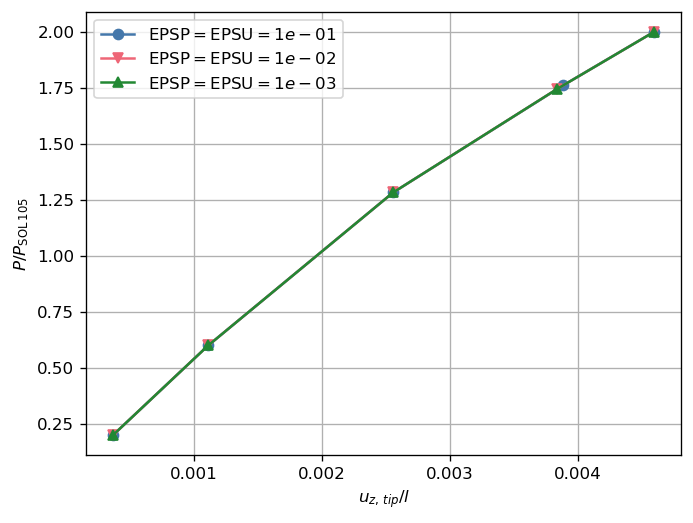

In [12]:
# Define error tolerances
tolerances = [1e-1, 1e-2, 1e-3]

# Create figure, run analysis for each couple of convergence tolerances and plot load-displacement diagram
ax = plt.subplot()
for count, tol in enumerate(tolerances):
    box_beam_bdf.nlparms[nlparm_id].eps_p = tol
    box_beam_bdf.nlparms[nlparm_id].eps_u = tol
    input_filename = f"nonlinear_analysis_load_tolerance_{tol:.0e}".replace('.','_')
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, markers[count], f"$\mathrm{{EPSP}}=\mathrm{{EPSU}}={tol:.0e}$", run_flag=False)

# Set plot appearance
plt.xlabel("$u_{z,\,tip}/l$")
plt.ylabel("$P/P_\mathrm{SOL\/105}$")
plt.legend()
plt.grid()
plt.show()

All the analyses appear to return the same equilibrium points, and for this reason we restore the default convergence tolerances.

In [13]:
box_beam_bdf.nlparms[nlparm_id].eps_p = 1e-2
box_beam_bdf.nlparms[nlparm_id].eps_u = 1e-2

### Initial load increment <a name="initial-load-increment"></a>

Next we consider three different values of initial load increment:
- $\Delta\mu^1=0.5$;
- $\Delta\mu^1=0.1$ (default);
- $\Delta\mu^1=0.01$.

Nastran job nonlinear_analysis_initial_load_increment5e-01.bdf completed
Wall time: 12.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-01.bdf completed
Wall time: 15.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-02.bdf completed
Wall time: 22.0 s


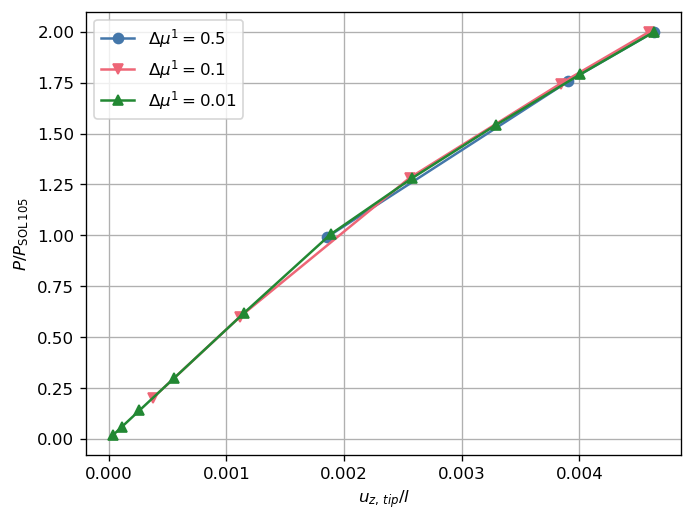

In [14]:
initial_load_increments = [.5, .1, .01]  # define list of initial load increments

# Create figure, run analysis for each initial load increment and plot load-displacement diagram
_, ax = plt.subplots()
for count, delta_mu_1 in enumerate(initial_load_increments):
    box_beam_bdf.nlparms[nlparm_id].ninc = round(1/delta_mu_1)
    input_filename = f"nonlinear_analysis_initial_load_increment{delta_mu_1:.0e}".replace('.','_')
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, markers[count], f"$\Delta\mu^1={delta_mu_1:.9g}$", run_flag=False)

# Set plot appearance
plt.xlabel("$u_{z,\,tip}/l$")
plt.ylabel("$P/P_\mathrm{SOL\/105}$")
plt.legend()
plt.grid()
plt.show()

The analysis with $\Delta\mu^1=0.1$ returns a final equilibrium point that is slightly different from the other two analyses. Consequently, this point might be a good candidate for the verification of the existence of other equilibrium paths.

## Verification of the existence of other equilibrium paths <a name="verification"></a>

***

We run a first analysis considering the curve obtained using $\Delta\mu^1=0.1$. We define the two subcases with the following nonlinear analysis parameters:

1. concentrated tip load, $\Delta\mu^1=0.1$, same remaining parameters as in the last analysis;
2. no load, fine nonlinear analysis parameters:
    - $\Delta\mu^1=0.01$,
    - $\mathrm{EPSP}=\mathrm{EPSU}=10^{-3}$,
    - $\mathrm{MAXBIS}=10$,
    - $\mathrm{MINALR}=0.01$,
    - $\mathrm{MAXALR}=1.0001$,
    - $\mathrm{DESITER}=5$.
    - $\mathrm{MXINC}=100$.

The idea is to use small arc-length increments in the second subcase while unloading the structure and see what happens.

In [15]:
# Modify nonlinear analysis parameters for first subcase
box_beam_bdf.nlparms[nlparm_id].ninc = 10

# Define load set with zero applied force
zero_load_set_id = load_set_id + 1  # id of LOAD card
box_beam_bdf.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[force_set_id])  # add LOAD card

# Create second subcase to unload the structure
second_subcase_id = 2
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=second_subcase_id, load_set_id=zero_load_set_id)  # create subcase with zero applied load
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, subcase_id=second_subcase_id, nlparm_id=second_subcase_id, ninc=100, conv='PUV', eps_p=1e-3,
                                         eps_u=1e-3, max_bisect=10, minalr=.01, maxalr=1.0001, desiter=5, maxinc=100)  # set up arc-length method for second subcase using parameters for very fine resolution of equilibrium path

Let's run the analysis by calling the function `run_tangent_stiffness_matrix_eigenvalue_calculation` from the `pynatran_utils` module. This function sets up the `BDF` object to calculate the lowest eigenvalue of the tangent stiffness matrix, runs the analysis, reads the resulting op2 file and returns the corresponding `OP2` object.

In [16]:
input_name = 'equilibrium_path_verification_deltamu1_1e-1'
upper_eigenvalue = 1e2  # define upper bound for eigenvalues to be computed in order to prevent eigensolver from being unable to find all modes in default range
sol_106_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=zero_load_set_id + 1, analysis_directory_path=ANALYSIS_DIRECTORY_PATH, upper_eig=upper_eigenvalue,
    lower_eig=-upper_eigenvalue, input_name=input_name, run_flag=False)

Nastran job equilibrium_path_verification_deltamu1_1e-1.bdf completed
Wall time: 253.0 s


Now we want to plot the load-displacement diagram and the eigenvalues $\lambda$ of the tangent stiffness matrix $\boldsymbol{K}_T$. In order to to this we define two functions.

In the first function, `plot_load_displacement_diagram`, we take as input the displacement and load history of all subcases, we create a new figure and we plot the applied load and the displacement for every converged iteration of each subcase. For this plot we always consider the tip displacement $u_{z,\,tip}$ nondimensioanlized with the length $l$ of the box beam.

In the second function, `plot_tangent_stiffness_matrix_eigenvalues`, we take as input the path to the analysis directory, the name of the Nastran input file and the load history of all subcases. The function reads the eigenvalues of the tangent stiffness matrix from the f06 file, and creates a new figure with two subplots. It then plots the eigenvalues against the iteration number in the first subplot and the eigenvalues against the applied loads in the second subplot. In this way we can observe how the eigenvalues evolve both as the nonlinear analysis walks forward through the subcases and in relation with the applied loads.

In [17]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']  # retrieve list with succession of standard matplotlib colors

def plot_load_displacement_diagram(disp, loads):
    load_displacement_ax = plt.subplot()  # create figure with one subplot
    for subcase in loads:  # iterate through the subcases
        load_displacement_ax.plot(disp[subcase][:, Z_COMPONENT_INDEX]/l, loads[subcase][:, Z_COMPONENT_INDEX]/SOL_105_BUCKLING_LOAD, marker=markers[subcase - 1],
                                   label=f"Subcase {subcase:d}")  # plot applied loads against displacement for each converged iteration
    load_displacement_ax.legend()  # set up legend
    plt.xlabel("$u_{z,\,tip}/l$")
    plt.ylabel("$P/P_\mathrm{SOL\/105}$")
    plt.grid()
    plt.show()

def plot_tangent_stiffness_matrix_eigenvalues(directory_path, input_name, loads):
    # Read eigenvalues from f06 file
    f06_path = os.path.join(directory_path, input_name + '.f06')  # path to .f06 file
    eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Create figure with 2 subplots
    _, eigvals_axs = plt.subplots(nrows=1, ncols=2, sharey='all')
    iterations_count = 1
    # Divide lowest eigenvalues by subcase and plot them
    eigenvalues_count = 0
    eigenvalues_by_subcase = {}
    for subcase in loads:
        no_load_steps = len(loads[subcase])
        eigenvalues_by_subcase[subcase] = eigvals[:, eigenvalues_count:eigenvalues_count + no_load_steps]
        eigenvalues_count += no_load_steps
        # Plot eigenvalues vs iteration number in first subplot
        eigvals_axs[0].plot(np.arange(iterations_count, eigenvalues_by_subcase[subcase].shape[1] + iterations_count), eigenvalues_by_subcase[subcase].T, markers[subcase - 1],
        color=COLORS[subcase - 1], label=f"Subcase {subcase:d}")
        iterations_count += eigenvalues_by_subcase[subcase].shape[1]
        # Plot eigenvalues vs applied load in second subplot
        eigvals_axs[1].plot(loads[subcase][:eigenvalues_by_subcase[subcase].shape[1], Z_COMPONENT_INDEX]/SOL_105_BUCKLING_LOAD, eigenvalues_by_subcase[subcase].T,
        markers[subcase - 1], color=COLORS[subcase - 1])
    # Set plot appearance
    eigvals_axs[0].set_xlabel("Iteration")
    eigvals_axs[0].set_ylabel("$\lambda$, N/mm")
    eigvals_axs[0].grid(visible=True)
    eigvals_axs[1].set_xlabel("$P/P_\mathrm{SOL\/105}$")
    eigvals_axs[1].grid(visible=True)
    plt.show()


Let's read the load-displacement history from the `OP2` object returned with the last analysis and plot both the load-displacement and the eigenvalue diagram.

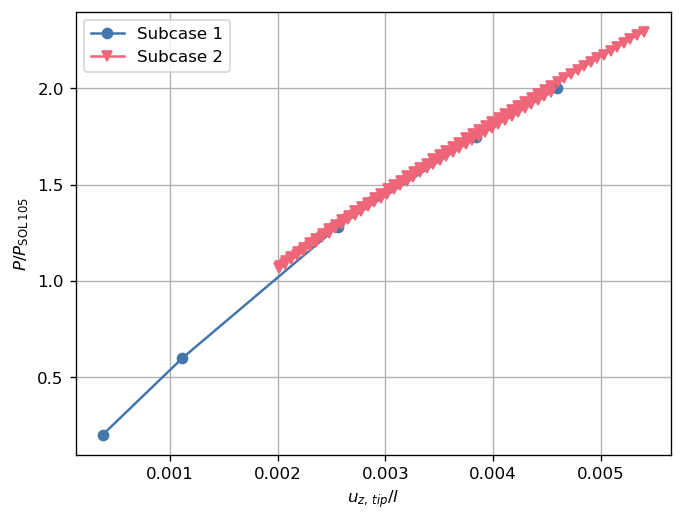

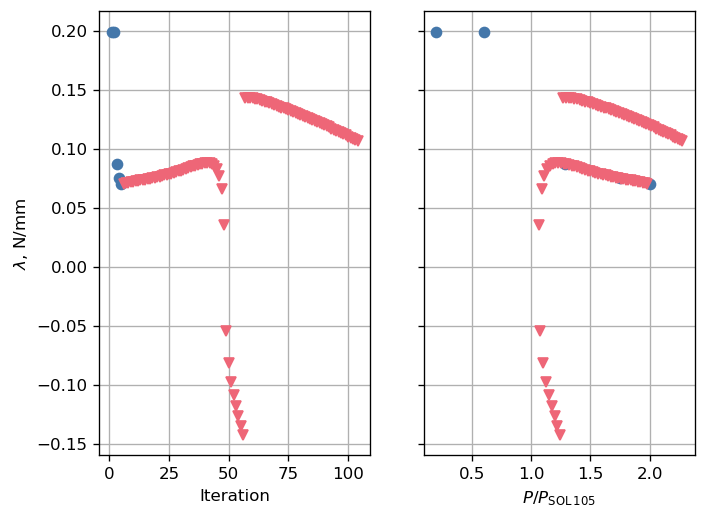

In [18]:
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2, displacement_node_id=tip_master_node_id)
plot_load_displacement_diagram(tip_displacements, applied_loads)
plot_tangent_stiffness_matrix_eigenvalues(ANALYSIS_DIRECTORY_PATH, input_name, applied_loads)

Surprise surprise! When we try to unload the box beam from the final point of the first subcase, we are actually unable to do it. The load and tip displacement initially decrease, but around $P/P_\text{SOL 105}=1.05$ they spring back along a different trajectory. This appears to be a proof of the existence of a complementary path in the equilibrium manifold of our box beam, that is to say an equilibrium path that is different from the natural path and cannot be reached from the ground state.

What's the nature of this new path that we have found? Looking at the eigenvalue diagram, we can see that the smallest magnitude eigenvalue crosses zero at approximately $P/P_\text{SOL 105}=1.05$ and becomes negative. This means that we have unstable equilibrium points for at least a portion of the path. However, the eigenvalue appears to have a discontinuous behavior during the analysis. Why is that? This is most probably related to the fact that we are using the Lanczos method to calculate the eigenvalues of $\boldsymbol{K}_T$. In fact, the Lanczos method calculates the first $N$ eigenvalues of a matrix from the smallest in magnitude to the largest. When we see a jump in the plot above, it is well possible that there is a change in which eigenvalue is the smallest in magnitude.

For this reason, we rerun the analysis calculating more than one eigenvalue of $\boldsymbol{K}_T$, setting $N=10$.

In [19]:
no_eigenvalues = 10
input_name = f"equilibrium_path_verification_deltamu1_1e-1_{no_eigenvalues:d}eigenvalues"
sol_106_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=zero_load_set_id + 1, upper_eig=upper_eigenvalue, lower_eig=-upper_eigenvalue,
    no_eigenvalues=no_eigenvalues, analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, run_flag=False)

Nastran job equilibrium_path_verification_deltamu1_1e-1_10eigenvalues.bdf completed
Wall time: 253.0 s


Let's read the load history and plot the eigenvalue diagram.

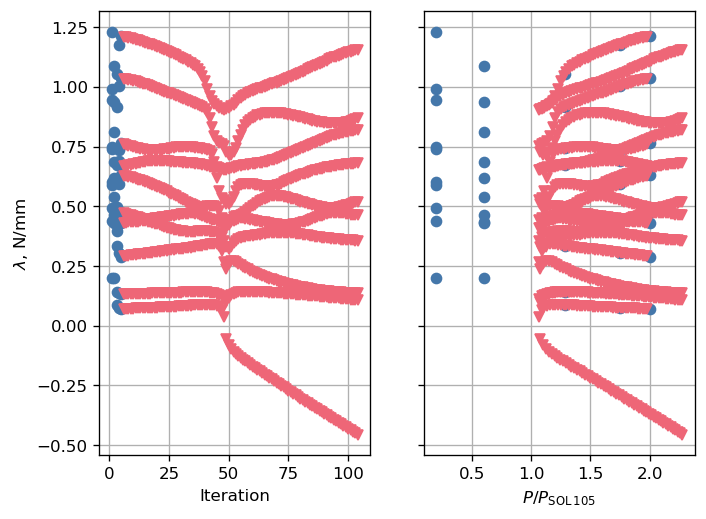

In [20]:
_, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2, displacement_node_id=tip_master_node_id)
plot_tangent_stiffness_matrix_eigenvalues(ANALYSIS_DIRECTORY_PATH, input_name, applied_loads)

From this plot we can observe that in the first subcase the box beam ends up on the stable portion of a complementary path. During the second subcase the structure transitions to the unstable part of the equilibrium path. This is different from what we observed in a [previous analysis](06_Verification_of_SOL_106_Nonlinear_Buckling_Method.ipynb#tangent-stiffness-matrix) of the unreinforced box beam, where by loading the structure from its ground state we found a fully stable natural path. In this case, the jump to another equilibrium path must be ascribed to the very large arc-length increment used in the first subcase, which allows the solver to find equilibrium points that are not on the natural path.

Now we want to get an additional proof that the newly found path is disconnected from the natural path of the box beam. For this reason, we are going to change the second subcase to unload the structure using the load control method. Our expectation is that, around $P/P_\text{SOL 105}=1.05$, we should observe a jump in both the load-displacement and in the eigenvalue diagrams. This is because the load control method will constrain the load to decrease even if there is no solution on the current equilibrium path, forcing the solver to find a solution on another path, which hopefully will correspond to the natural path.

Let's modify our `BDF` object by removing the `NLPCI` card, to enable the load control method, and by increasing the maximum number of iteration for each load increment.

In [21]:
del box_beam_bdf.nlpcis[2]  # remove NLPCI card

Now let's run the analysis and plot both the load-displacement and the eigenvalue diagrams.

Nastran job equilibrium_path_verification_deltamu1_1e-1_10eigenvalues_load_control.bdf completed
Wall time: 271.0 s


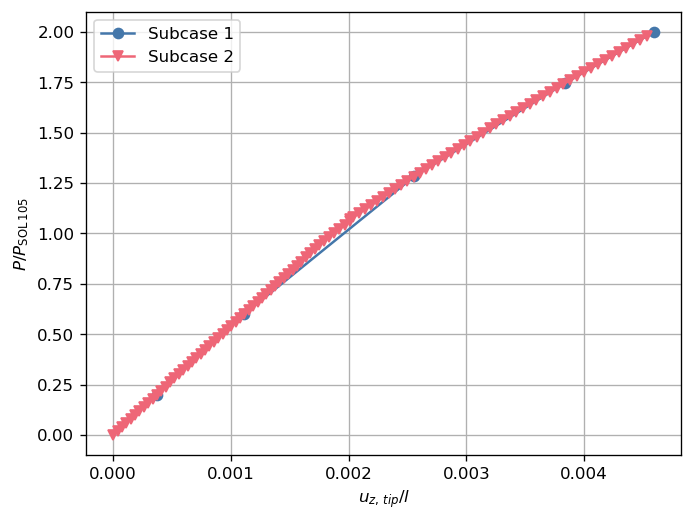

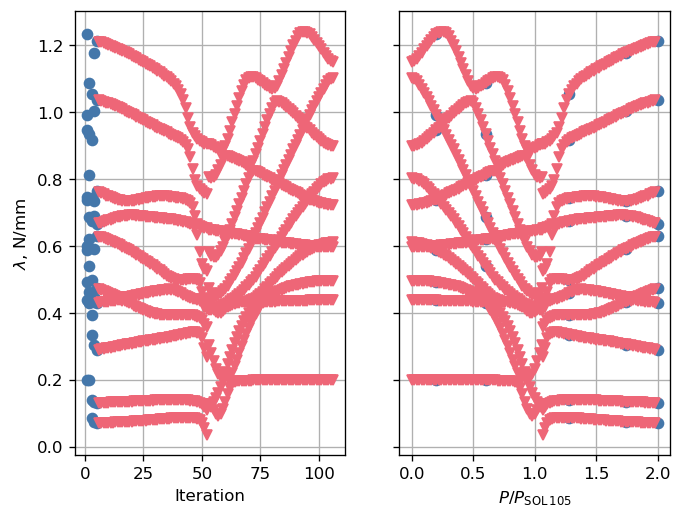

In [22]:
input_name = f"equilibrium_path_verification_deltamu1_1e-1_{no_eigenvalues:d}eigenvalues_load_control"
sol_106_load_control_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=zero_load_set_id + 1, upper_eig=upper_eigenvalue, lower_eig=-upper_eigenvalue, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, run_flag=False)
_, applied_loads_load_control, tip_displacements_load_control = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_load_control_op2, displacement_node_id=tip_master_node_id)
plot_load_displacement_diagram(tip_displacements_load_control, applied_loads_load_control)
plot_tangent_stiffness_matrix_eigenvalues(ANALYSIS_DIRECTORY_PATH, input_name, applied_loads_load_control)

Even if we can't immediately see the jump in the load-displacement diagram, this is evident in the eigenvalue diagram, where we can notice that the trajectory of the lowest eigenvalue in the second subcase suddenly stops at approximately $P/P_\text{SOL 105}=1.05$.

What happens if we unload the box beam from the final equilibrium point of the other two analyses of the intial load increment sweep? Since the final equilibrium point appears to be the same, we only investigate the case with $\Delta\mu^1=0.5$.

We define the following two subcases:

1. concentrated tip load, $\Delta\mu^1=0.5$, same remaining parameters as in the previous analysis with coarse arc-length increments;
2. no load, fine nonlinear analysis parameters:
    - $\Delta\mu^1=0.01$,
    - $\mathrm{EPSP}=\mathrm{EPSU}=10^{-3}$,
    - $\mathrm{MAXBIS}=10$,
    - $\mathrm{MINALR}=0.01$,
    - $\mathrm{MAXALR}=1.0001$,
    - $\mathrm{DESITER}=5$.
    - $\mathrm{MXINC}=100$.

Let's modify the initial load increment for the first subcase, turn back on the arc-length method for the second subcase, run the analysis and plot the results.

Nastran job equilibrium_path_verification_deltamu1_5e-1.bdf completed
Wall time: 225.0 s


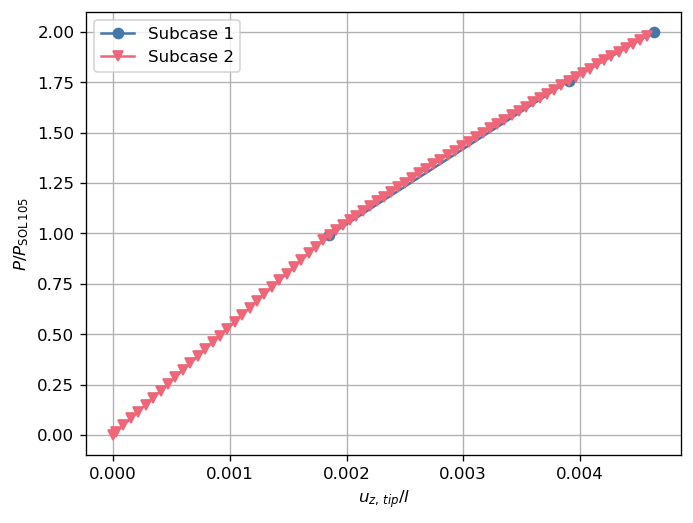

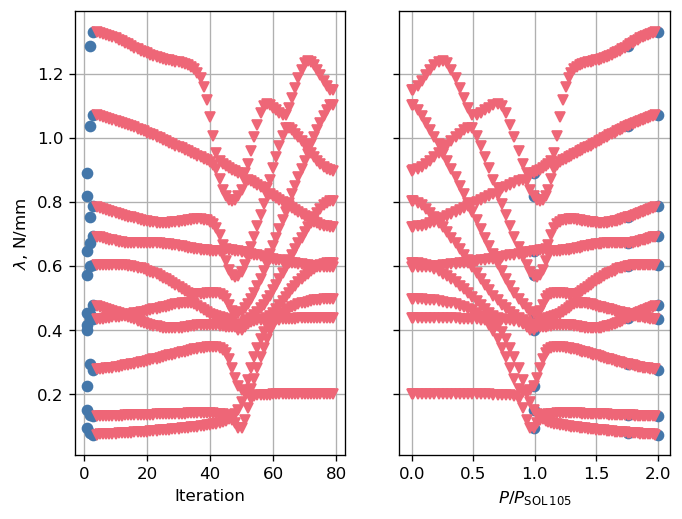

In [23]:
# Modify convergence tolerances of first subcase
box_beam_bdf.nlparms[nlparm_id].ninc = 2

# Reactivate arc-length method for second subcase
box_beam_bdf.add_nlpci(nlpci_id=second_subcase_id, Type='CRIS', maxalr=1.0001, minalr=1e-2, desiter=5, mxinc=100)

# Run analysis
input_name = f"equilibrium_path_verification_deltamu1_5e-1".replace('.','_')
sol_106_deltamu1_5em1_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=zero_load_set_id + 1, upper_eig=upper_eigenvalue, lower_eig=-upper_eigenvalue, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, run_flag=False)  # run analysis and read OP2 file

# Plot results
_, applied_loads_deltamu1_5em1, tip_displacements_deltamu1_5em1 = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_deltamu1_5em1_op2, displacement_node_id=tip_master_node_id)  # find load and displacement history
plot_load_displacement_diagram(tip_displacements_deltamu1_5em1, applied_loads_deltamu1_5em1)  # plot load-displacement diagram
plot_tangent_stiffness_matrix_eigenvalues(ANALYSIS_DIRECTORY_PATH, input_name, applied_loads_deltamu1_5em1)  # plot eigenvalue diagram

In this case, the box beam is completely unloaded during the second subcase, meaning that the solver moved along the natural path of the structure. In fact, we can observe that all eigenvalues of $\boldsymbol{K_T}$ are always positive, and that there is no jump in their trajectory. This means that the first subcase ends on an equilibrium point of the natural equilibrium path and as a consequence we are able to completely unload the structure from such point.

## Visualization of 3D equilibrium diagram and deformation shapes <a name="visualization"></a>

***

Now we want to visualize together the natural and the complementary path. Doing this on a 2D equilibrium path visualizing only at the tip displacement would most probably not result more insigthful than our previous plots. So, how can we achieve a better characterization of the differences among the paths? If we consider the tip displacement as a surrogate of the global deformation state of the structure, we could think of another surrogate giving us an idea of the local deformation state. In that way, we could plot a 3D load-displacement diagram with the applied load against the tip and the local displacement.

Considering the nonlinear deformation shape of the box beam obtained in our previous analyses, an appropriate choice for the local displacement could be the displacement along the $z$-axis of the node where we observe the maximum displacement in the linear buckling analysis (SOL 105). As a consequence, we delete our previous subcases and call the function `run_sol_105_buckling_analysis` from the `pynastran_utils` module to find the id of the node where the maximum displacement occurs.

In [24]:
# Delete subcases 1 and 2
for subcase_id in range(1, 3):
    del box_beam_bdf.subcases[subcase_id]

# Run linear buckling analysis
input_name = "linear_buckling_analysis"
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=box_beam_bdf.__deepcopy__({}), static_load_set_id=force_set_id,
analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, run_flag=False)

# Find id of node where maximum displacement occurs
max_displacement_node_id = np.argmax(sol_105_op2.eigenvectors[second_subcase_id].data[0, :, Z_COMPONENT_INDEX]) + 1

Let's visualize the position of the node.

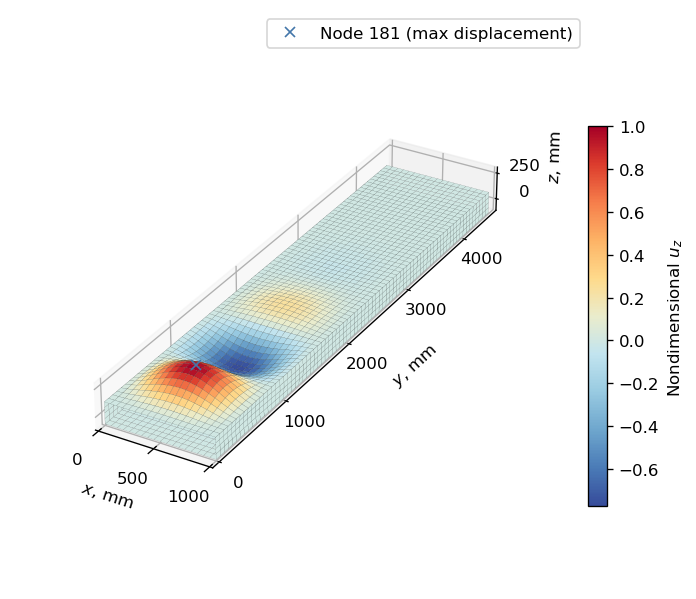

In [25]:

# Plot critical buckling mode
displacement_amplification_factor = 200  # define amplification factor for displacements
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=second_subcase_id, displacement_component='tz', colormap='sunset',
                                                 displacement_amplification_factor=displacement_amplification_factor)

# Plot node of max displacement
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz + displacement_amplification_factor*sol_105_op2.eigenvectors[second_subcase_id].data[0, max_displacement_node_id - 1, 0:3]  # we multiply the eigenvector by the default displacement scale factor of plot_buckling_mode
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x', label=f"Node {max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend()

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis='x', nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis='z', nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis='y', which='major', pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis='z', which='major', pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 60  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-0.05, .14))  # move colorbar upwards

# Set axes ticks and labels' position and show plot
adjust_3d_plot(ax, cbar)
plt.show()

The last step before producing our 3D equilibrium diagram consists in finding the local displacement history at node 181 for the natural and complementary paths. For the latter we are going to use the results of the second subcase of the analysis with $\Delta\mu^1=0.5$.

In [26]:
_, _, local_displacements_natural_path = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_deltamu1_5em1_op2,
displacement_node_id=max_displacement_node_id)
_, _, local_displacements_complementary_path = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2,
displacement_node_id=max_displacement_node_id)

We can now produce our 3D equilibrium diagram, where we nondimensionalize the local displacement with the width of the box beam.

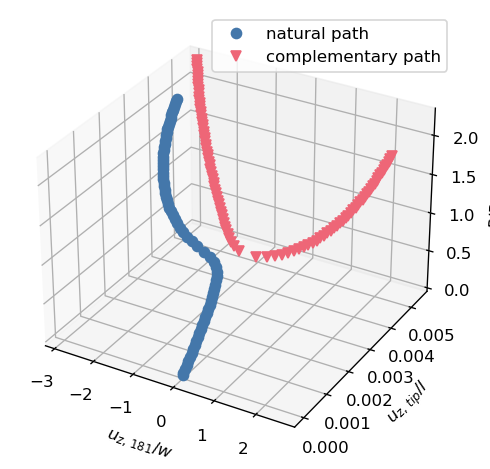

In [27]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection='3d')

# Plot applied load against tip and local displacements
nondimensional_local_displacements = {"natural path": local_displacements_natural_path[second_subcase_id][:, Z_COMPONENT_INDEX]/2,
                                      "complementary path": local_displacements_complementary_path[second_subcase_id][:, Z_COMPONENT_INDEX]/2}
nondimensional_tip_displacements = {"natural path": tip_displacements_deltamu1_5em1[second_subcase_id][:, Z_COMPONENT_INDEX]/l,
                                    "complementary path": tip_displacements[second_subcase_id][:, Z_COMPONENT_INDEX]/l}
nondimensional_applied_loads = {"natural path": applied_loads_deltamu1_5em1[second_subcase_id][:, Z_COMPONENT_INDEX]/SOL_105_BUCKLING_LOAD,
                                "complementary path": applied_loads[second_subcase_id][:, Z_COMPONENT_INDEX]/SOL_105_BUCKLING_LOAD}
for count, key in enumerate(nondimensional_local_displacements.keys()):
    ax_3d.plot3D(nondimensional_local_displacements[key], nondimensional_tip_displacements[key], nondimensional_applied_loads[key],
                 markers[count], color=COLORS[count], label=key)  # plot applied loads against tip and local displacements

# Set plot appearance
ax_3d.set_xlabel(f"$u_{{z,\,{max_displacement_node_id:d}}}/w$")
ax_3d.set_ylabel("$u_{z,\,tip}/l$")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
ax_3d.legend()
plt.show()

With this plot we can get a clear visualization of the disconnection between the natural and the complementary path. However, we should remind that the equilibrium manifold of our box beam has actually as many dimensions as the number of the degrees of freedom plus the number of controlling parameters (only the magnitude of the applied load in this case). This means that our 3D equilibrium diagram is only an extremely partial representation of the equilibrium manifold and the fact that the paths appear disconnected for the investigated range of loads and displacements does not imply that the paths might not connect eslewhere in the equilibrium manifold. Nonetheless, this result is useful to make us aware that, while we are right to expect a stable natural equilibrium path without critical points for a box beam with a concetrated load at the tip, we might jump on a complementary path if the arc-length increment is large enough to allow the solver to do so.

What is the deformation shape along the different equilibrium paths? Let's explore this by cutting the equilibrium paths with a plane at $P/P_\text{SOL 105}=1.9$.

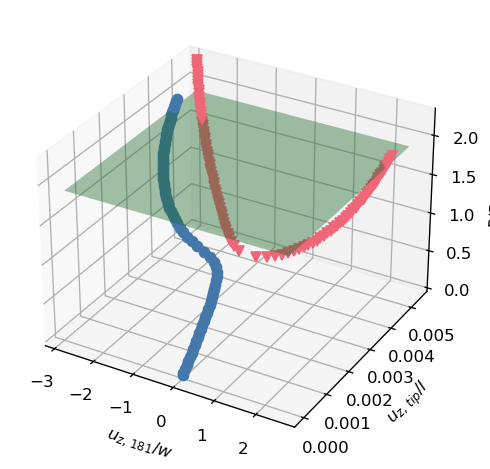

In [28]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection='3d')

# Plot part of the equilibrium paths that should not be visible on top of the plane
load_factor = 1.9
for count, key in enumerate(nondimensional_local_displacements.keys()):
    ax_3d.plot3D(nondimensional_local_displacements[key], nondimensional_tip_displacements[key],
                 np.where(nondimensional_applied_loads[key] < load_factor, nondimensional_applied_loads[key], np.nan),
                 markers[count], color=COLORS[count])

# Plot P/Psol105=1.9 plane
local_displacements_array = np.concatenate(tuple(nondimensional_local_displacements[key] for key in nondimensional_local_displacements))
tip_displacements_array = np.concatenate(tuple(nondimensional_tip_displacements[key] for key in nondimensional_tip_displacements))
xx, yy = np.meshgrid([np.min(local_displacements_array), np.max(local_displacements_array)], [np.min(tip_displacements_array),
                                                                                              np.max(tip_displacements_array)])
ax_3d.plot_surface(xx, yy, np.full_like(xx, load_factor), alpha=0.4, color=COLORS[len(nondimensional_local_displacements)])

# Plot part of the equilibrium paths that should be visible on top of the plane
for count, key in enumerate(nondimensional_local_displacements.keys()):
    ax_3d.plot3D(nondimensional_local_displacements[key], nondimensional_tip_displacements[key],
                 np.where(nondimensional_applied_loads[key] >= load_factor, nondimensional_applied_loads[key], np.nan),
                 markers[count], color=COLORS[count], zorder=3)

# Set plot appearance
ax_3d.set_xlabel(f"$u_{{z,\,{max_displacement_node_id:d}}}/w$")
ax_3d.set_ylabel("$u_{z,\,tip}/l$")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
plt.show()

Let's plot the deformation shape at the closest equilibrium points to the $P/P_\text{SOL 105}=1.9$ plane.

Deformation on natural path:


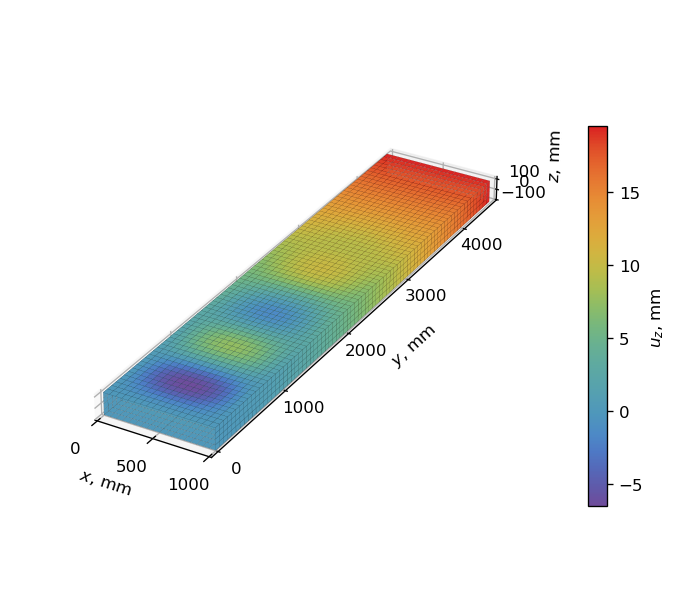

Deformations on unstable path:


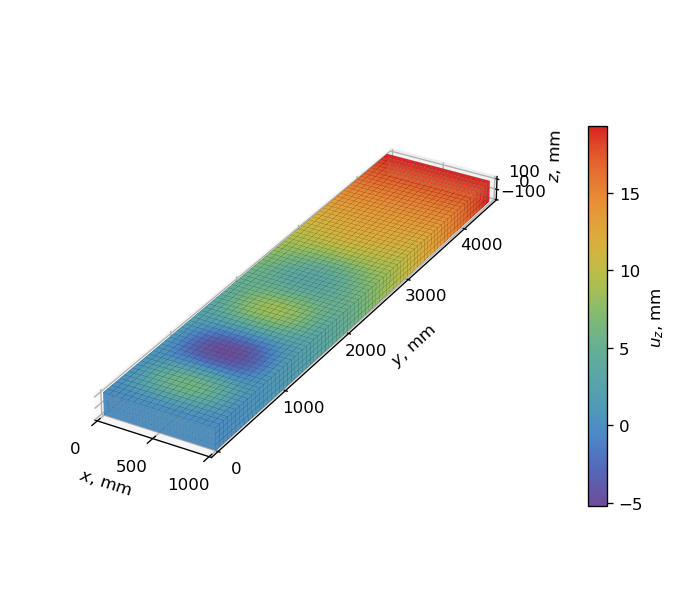

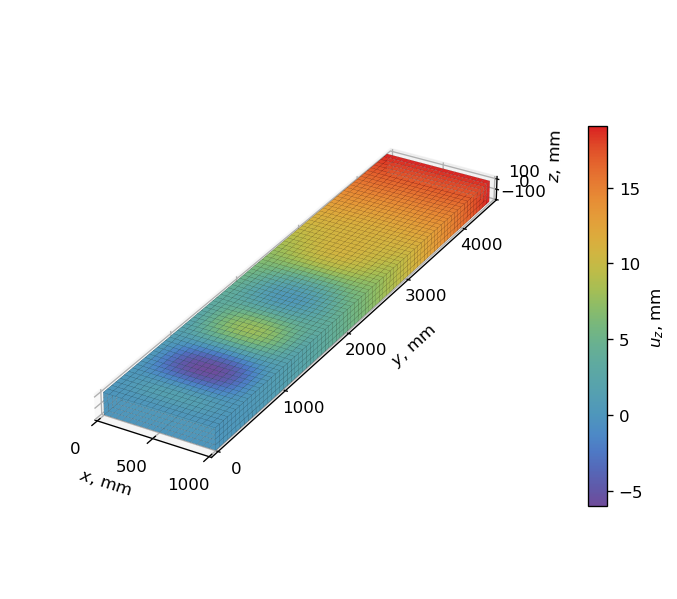

In [29]:
# Plot static deformation of natural path
print("Deformation on natural path:")
load_step = np.argmin(np.abs(nondimensional_applied_loads["natural path"] - load_factor)) + 1  # find closest load step to plane
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_deltamu1_5em1_op2, subcase_id=second_subcase_id,
                                                      load_step=load_step, displacement_component='tz')
adjust_3d_plot(ax, cbar)
plt.show()

# Plot first deformation on unstable path
print("Deformations on unstable path:")
min_load_index = np.argmin(nondimensional_applied_loads[key])
load_step = np.argmin(np.abs(nondimensional_applied_loads[key][:min_load_index] - load_factor)) + 1  # find closest load step to plane on first side of the path
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2, subcase_id=second_subcase_id,
                                                      load_step=load_step, displacement_component='tz')
adjust_3d_plot(ax, cbar)
plt.show()

# Plot second deformation on unstable path
load_step = np.argmin(np.abs(nondimensional_applied_loads[key][min_load_index:] - load_factor)) + min_load_index + 1  # find closest load step to plane on second side of the path
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2, subcase_id=second_subcase_id,
                                                      load_step=load_step, displacement_component='tz')
adjust_3d_plot(ax, cbar)
plt.show()

## Conclusions <a name="conclusions"></a>

***

In this notebook we have verified the existence of at least one complementary path for the unreinforced box beam beyond the natural path. This was possible by choosing very coarse arc-length increments and by playing around with the initial load increment of the nonlinear analysis. We acknowledge that the procedure employed here is rather random, as there is no way to tell a priori whether the selection of a certain value for a certain nonlinear analysis parameter will lead the arc-length solver to land on the natural path or on a complementary path. Furthermore, our investigation does not represent by any means an exhaustive study on all other possible complementary paths that might be present in the vicinity of the natural path. An appropriate tool would be needed to perform this study, as Nastran does not offer any means to perform this investigation in a systematic way. However, this is beyond the scope of our focus.

Nonetheless we gained useful insights and we were able to plot 3D equilibrium diagrams depicting at the same time the global and the local deformation state of the box beam. The tip displacement was used as a surrogate for the global state, while the displacement along $z$ of the node with the largest displacement predicted by the linear buckling analysis was used for the local state.

Overall, we understood that while we are right to expect a stable natural path without critical points for a box beam with a concetrated load at the tip, the solver might jump on a complementary path if the arc-length increments are too large.

In the [next notebook](15_Investigation_of_the_Equilibrium_Paths_of_the_Box_Beam_Reinforced_with_Ribs.ipynb) we will carry out an analogous investigation on the box beam reinforced with ribs.